This notebook demonstrates the following results of the paper for a reduced leak potassium conductance configuration compared to baseline without stimulation:
- Reduced delta, theta, alpha bands power
- Increased LZc

In [28]:
%precision 2
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from einops import reduce
from scipy.stats import ttest_ind
from tvbsim.receptors import conversion, get_g_K_values
from tvbsim.simconfig import SimConfig
from tvbsim.run_simulations import run_n_complete_parallelized
from tvbsim.frequency import plot_mean_power_seeds
from tvbsim.parameter import ListParameter
from tvbsim.plotting import plot_tvb_results, plot_box_points_violin
from tvbsim.common import get_result, retrieve_one_sim
from tvbsim.entropy.measures import parallelized_entropy
from tvbsim.TVB.tvb_model_reference.simulation_file.parameter.parameter_M_Berlin_new import Parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

Fix start and end (respectively before and after leak conductance reduction) reversal potential (E_L_e for excitatory population, E_L_i for inhibitory). Choose a connectome.

In [2]:
# general_parameters are parameters applied to all SimConfigs, instantiated with default values found in:
# tvbsim/TVB/tvb_model_reference/simulation_file/parameter/parameter_M_berlin_new
general_parameters = Parameters()

E_L_e_start = general_parameters.parameter_model['E_L_e']
E_L_i_start = general_parameters.parameter_model['E_L_i']
E_L_e_end = -61.2
E_L_i_end = -64.4

connectome = 'DK68' # 'Lausanne463'

Define the simulations, the save path etc

In [4]:
# Reduce if crashes happen
n_tasks_concurrent = 7

# run_sim is the length of the simulations (in ms)
# cut_transient is the amount of time that will be removed for analyses
run_sim = 5000.0
cut_transient = 4000.0

# stop_conditions is a list of conditions s.t. if they are satisfied the simulation stops (see documentation of run_simulation for details)
# useful to remove "explosions", simulations where firing rate goes to 200Hz and never comes down
stop_conditions = [(1,0,-np.inf,150*1e-3,1500)]

# n_minimal_seeds is the number of seeds that should finish before we can consider simulations done
# max_seed sets the highest number of seeds after which no more simulations will be ran
max_seed = 30
n_minimal_seeds = 15

# Define connectome (region positions, tract lengths, weights) used
path = os.getcwd()
if connectome == 'DK68':
    general_parameters.parameter_connection_between_region['path'] = f'{path}/data/connectivity/DK68'
    general_parameters.parameter_connection_between_region['conn_name'] = 'connectivity_68_QL20120814.zip'
    receptors = np.loadtxt('./data/receptors/DK68/5HT2a_reordered.txt')
elif connectome == 'Lausanne463':
    general_parameters.parameter_connection_between_region['path'] = f'{path}/data/connectivity/Lausanne463'
    general_parameters.parameter_connection_between_region['conn_name'] = 'connectivity_cortical_Lausanne463.zip'
    receptors = np.loadtxt('./data/receptors/Lausanne463/5HT2A_Lausanne463_cortical.txt')
else:
    raise Exception('variable connectome should be either DK68 or Lausanne463')

# Compute g_K values before and after leak conductance reduction based on reversal potential values chosen
E_K_e = general_parameters.parameter_model['E_K_e']
E_K_i = general_parameters.parameter_model['E_K_i']
E_Na_e = general_parameters.parameter_model['E_Na_e']
E_Na_i = general_parameters.parameter_model['E_Na_i']
g_L = general_parameters.parameter_model['g_L']

g_K_e_nopsi,g_Na_e_nopsi = conversion(E_Na=E_Na_e, E_K=E_K_e, E_L=E_L_e_start, g_L=g_L)
g_K_e_psi,g_Na_e_psi = conversion(E_Na=E_Na_e, E_K=E_K_e, E_L=E_L_e_end, g_Na=g_Na_e_nopsi)
g_K_i_nopsi,g_Na_i_nopsi = conversion(E_Na=E_Na_i, E_K=E_K_i, E_L=E_L_i_start, g_L=g_L)
g_K_i_psi,g_Na_i_psi = conversion(E_Na=E_Na_i, E_K=E_K_i, E_L=E_L_i_end, g_Na=g_Na_i_nopsi)

# Build parameter dictionaries for the two simulations (with and without potassium leak conductance reduction)
params_nopsi = {'g_K_e':g_K_e_nopsi, 'g_Na_e':g_Na_e_nopsi, 'g_K_i':g_K_i_nopsi, 'g_Na_i':g_Na_i_nopsi}
params_psi = {
    'g_K_e':ListParameter('g_K_e', get_g_K_values(g_K_e_nopsi, g_K_e_psi, receptors=receptors), f'prop_{E_L_e_end}'),
    'g_K_i':ListParameter('g_K_i', get_g_K_values(g_K_i_nopsi, g_K_i_psi, receptors=receptors), f'prop_{E_L_i_end}'),
    'g_Na_e':g_Na_e_psi, 
    'g_Na_i':g_Na_i_psi}

# Build simconfigs from parameter dictionaries
simconfigs = [
    SimConfig(general_parameters, run_sim, cut_transient, parameters=params_nopsi, stop_conditions=stop_conditions, 
              params_to_report=['g_K_e','g_K_i','g_Na_e','g_Na_i']),
    SimConfig(general_parameters, run_sim, cut_transient, parameters=params_psi, stop_conditions=stop_conditions,
              params_to_report=['g_K_e','g_K_i','g_Na_e','g_Na_i'])
]

# Define in which folder the simulation folders will be made (one folde rper seed per simulation)
simu_path = f'./result/{connectome}'
img_save_path = f'./img/{connectome}'

# Run simulations

In [5]:
# noexp_ai_seeds will hold the seeds for which the simulation did not stop
noexp_ai_seeds = np.zeros((len(simconfigs),n_minimal_seeds), dtype=int)
for i,simconfig in enumerate(simconfigs):
    noexp_ai_seeds[i] = run_n_complete_parallelized(
        simconfig, max_seed=max_seed, save_path_root=simu_path, n_minimal_seeds=n_minimal_seeds, n_tasks_concurrent=n_tasks_concurrent)

path = path = path =  path =   ./result/DK68/g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_2./result/DK68/g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_3path = path = 
 ./result/DK68/g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_0Initialize Simulator 
 

./result/DK68/g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_5Setting seed to 2./result/DK68/g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_6./result/DK68/g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_4


Initialize Simulator
path = Initialize SimulatorSetting seed to 4 ./result/DK68/g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_1

Initialize SimulatorInitialize Simu

Get excitatory population firing rates data from the simulation files.

In [40]:
data = []
for i,simconfig in enumerate(simconfigs):
    data_simconf = []
    for j,seed in enumerate(noexp_ai_seeds[i]):
        data_simconf.append(retrieve_one_sim(simconfig, seed, root=simu_path))
    data.append(data_simconf)
data = np.array(data)

Loading:  ./result/DK68 g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_0
(10000, 68)
Loading:  ./result/DK68 g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_1
(10000, 68)
Loading:  ./result/DK68 g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_2
(10000, 68)
Loading:  ./result/DK68 g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_3
(10000, 68)
Loading:  ./result/DK68 g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_4
(10000, 68)
Loading:  ./result/DK68 g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_5
(10000, 68)
Loading:  ./result/DK68 g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_6
(10000, 68)
Loading:  ./result/DK68 g_K_e_8.07

# Analysis

Plot the firing rates of excitatory populations along time during the simulation.

0
Saving plot
g_K_e = 8.07, g_K_i = 8.21, g_Na_e = 1.93, g_Na_i = 1.79


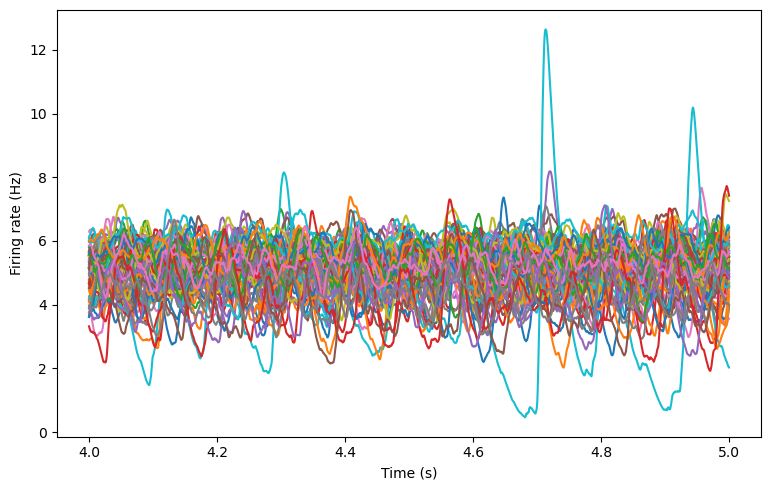

0
Saving plot
g_K_e = prop_-61.2, g_K_i = prop_-64.4, g_Na_e = 1.93, g_Na_i = 1.79


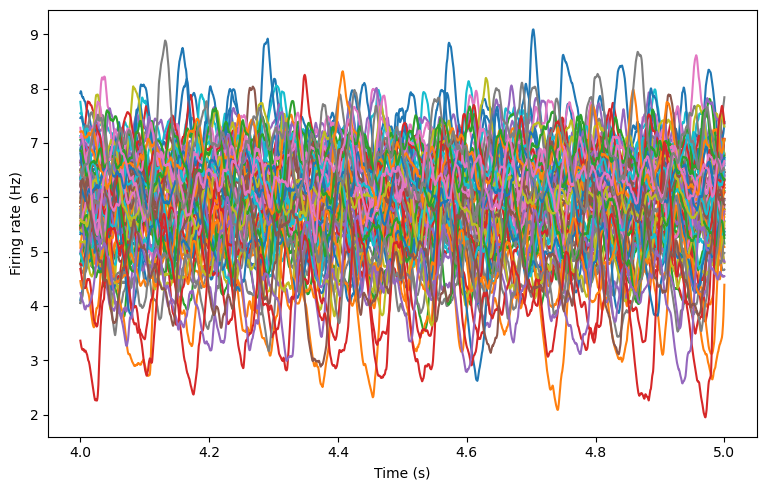

In [72]:
# Which variables to load ('E' is excitatory, the only variable saved by default 
# This can be changed in general_parameters.parameter_monitor['parameter_Raw']['variables_of_interest'] by adding 1,2,3 etc
# The list of variables of the model can be found in the documentation of get_result in tvbsim.common
vars_int = ['E']
monitor = 'Raw'
for i,simconfig in enumerate(simconfigs):
    plot_tvb_results([simconfig], [[[data[i][:1]]]], monitor, for_explan, vars_int, seeds=noexp_ai_seeds[i][:1], 
                     figsize=(15,5), save=1, begin_time=4., end_time=5.,
                     priority_regions=[0], save_path=img_save_path, regions=None, with_title=False)

In [74]:
# Compute mean & std of firing rates across time of all channels for all seeds
means = reduce(data, 'c s t r -> c (s r)', np.mean)
stds = reduce(data, 'c s t r -> c (s r)', np.std)
std_across_all_channels = reduce(data, 'c s t r -> c s', np.std)

print('Average channel mean in baseline', np.mean(means[0]))
print('Average channel mean in reduced K+ leak conductance setting', np.mean(means[1]))
print(ttest_ind(means[0], means[1], equal_var=False).pvalue)
print('Average per-channel standard deviation in baseline', np.mean(stds[0]))
print('Average per-channel standard deviation in reduced K+ leak conductance setting', np.mean(stds[1]))
print(ttest_ind(stds[0], stds[1], equal_var=False).pvalue)
print('Average total standard deviation in baseline', np.mean(std_across_all_channels[0]))
print('Average total standard deviation in reduced K+ leak conductance setting', np.mean(std_across_all_channels[1]))
print(ttest_ind(std_across_all_channels[0], std_across_all_channels[1], equal_var=False).pvalue)

Average channel mean in baseline 5.100264861626258
Average channel mean in reduced K+ leak conductance setting 5.860243151105688
3.72575681414421e-120
Average per-channel standard deviation in baseline 0.5259867166713217
Average per-channel standard deviation in reduced K+ leak conductance setting 0.48210927584779784
7.977679691520119e-07
Average total standard deviation in baseline 0.7838270241763802
Average total standard deviation in reduced K+ leak conductance setting 0.9492545411662776
2.4048321551506907e-21


Compute & plot the spectrum of the firing rates.

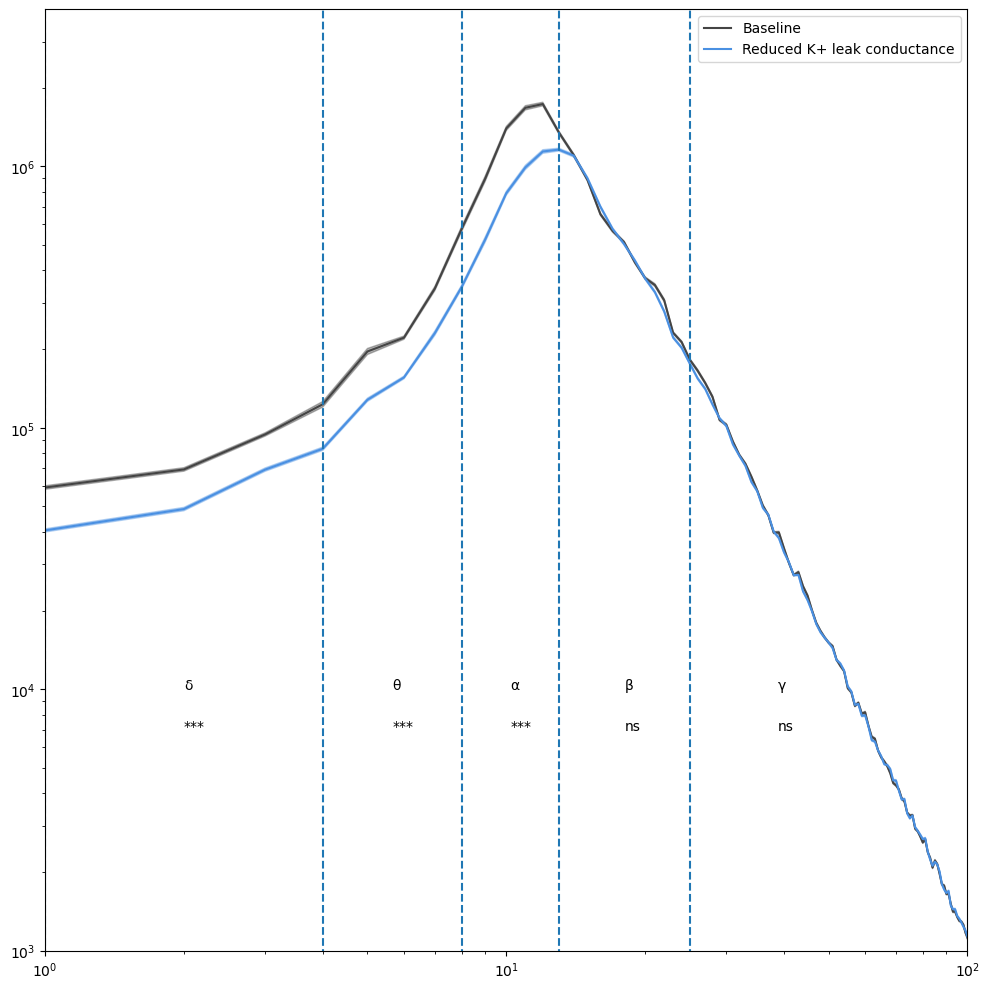

In [70]:
x = ['Baseline','Reduced K+ leak conductance']
colors = ['#444444', '#4A90E2']
plot_mean_power_seeds(
    simconfigs, seeds_sets=noexp_ai_seeds, ignore_exists=True,
    root=simu_path, figsize=(10,10), 
    labels=x, color1s=colors, color2s=colors,
    save=1, save_path=img_save_path, regions=None,
    file_name=f'spectrum.png', data=data, TR=0.1) # 10 datapoints per ms

Compute & plot Lempel-Ziv complexity (LZc).

Following config done:
 run_sim = 5000.0, cut_transient = 4000.0
custom parameters = {'g_K_e': 8.071428571428571, 'g_Na_e': 1.9285714285714288, 'g_K_i': 8.214285714285714, 'g_Na_i': 1.7857142857142865}
special parameters = []
Saved at : LZc_single_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_15.npy
Following config done:
 run_sim = 5000.0, cut_transient = 4000.0
custom parameters = {'g_K_e': <tvbsim.parameter.ListParameter object at 0x7f38ea980d60>, 'g_K_i': <tvbsim.parameter.ListParameter object at 0x7f38ea9803d0>, 'g_Na_e': 1.9285714285714288, 'g_Na_i': 1.7857142857142865}
special parameters = ['g_K_e', 'g_K_i']
Saved at : LZc_single_g_K_e_prop_-61.2_g_K_i_prop_-64.4_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_15.npy
LZc_single_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_15.npy found (minimal seed count match) at path ./result/DK68.
LZc_single_g_K_e_prop_-61.2_g_K_i_

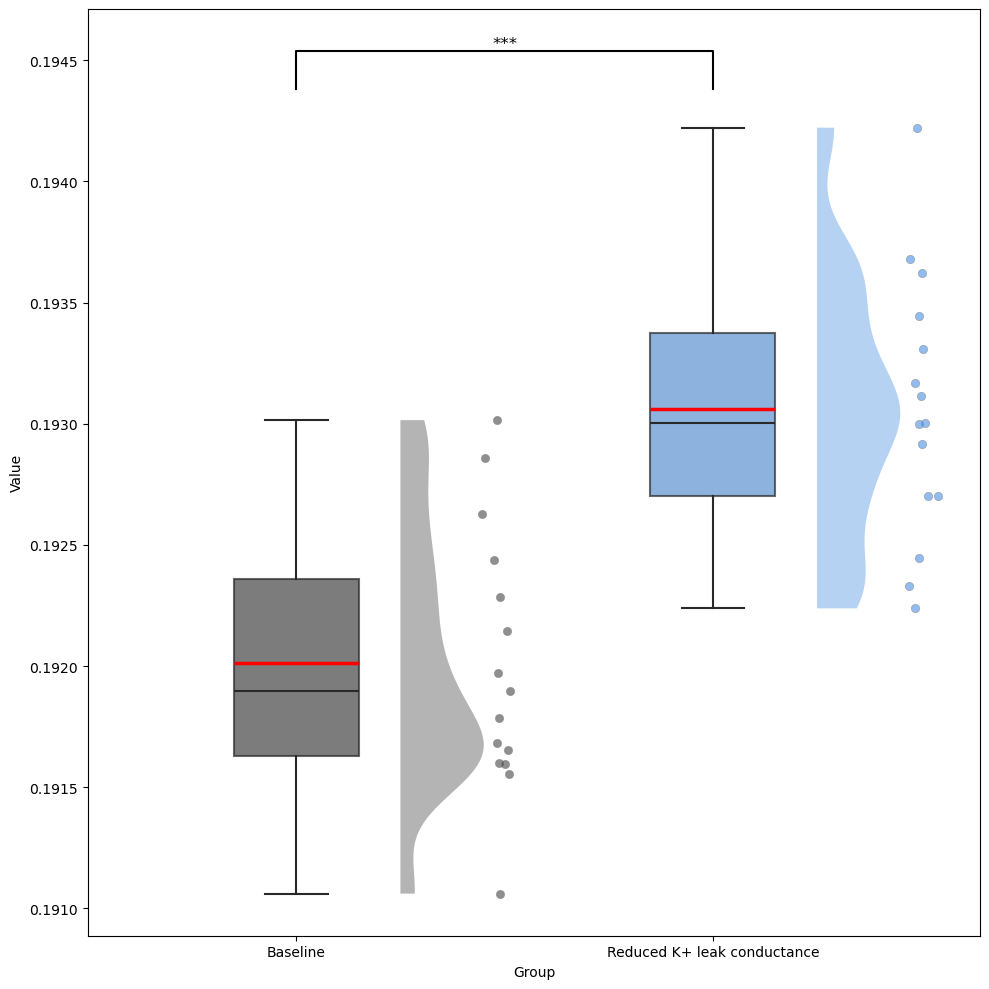

Following config done:
 run_sim = 5000.0, cut_transient = 4000.0
custom parameters = {'g_K_e': 8.071428571428571, 'g_Na_e': 1.9285714285714288, 'g_K_i': 8.214285714285714, 'g_Na_i': 1.7857142857142865}
special parameters = []
Saved at : LZc_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_15.npy
Following config done:
 run_sim = 5000.0, cut_transient = 4000.0
custom parameters = {'g_K_e': <tvbsim.parameter.ListParameter object at 0x7f38ea980d60>, 'g_K_i': <tvbsim.parameter.ListParameter object at 0x7f38ea9803d0>, 'g_Na_e': 1.9285714285714288, 'g_Na_i': 1.7857142857142865}
special parameters = ['g_K_e', 'g_K_i']
Saved at : LZc_g_K_e_prop_-61.2_g_K_i_prop_-64.4_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_15.npy
LZc_g_K_e_8.071428571428571_g_K_i_8.214285714285714_g_Na_e_1.9285714285714288_g_Na_i_1.7857142857142865_15.npy found (minimal seed count match) at path ./result/DK68.
LZc_g_K_e_prop_-61.2_g_K_i_prop_-64.4_g_Na_e_1.92857142

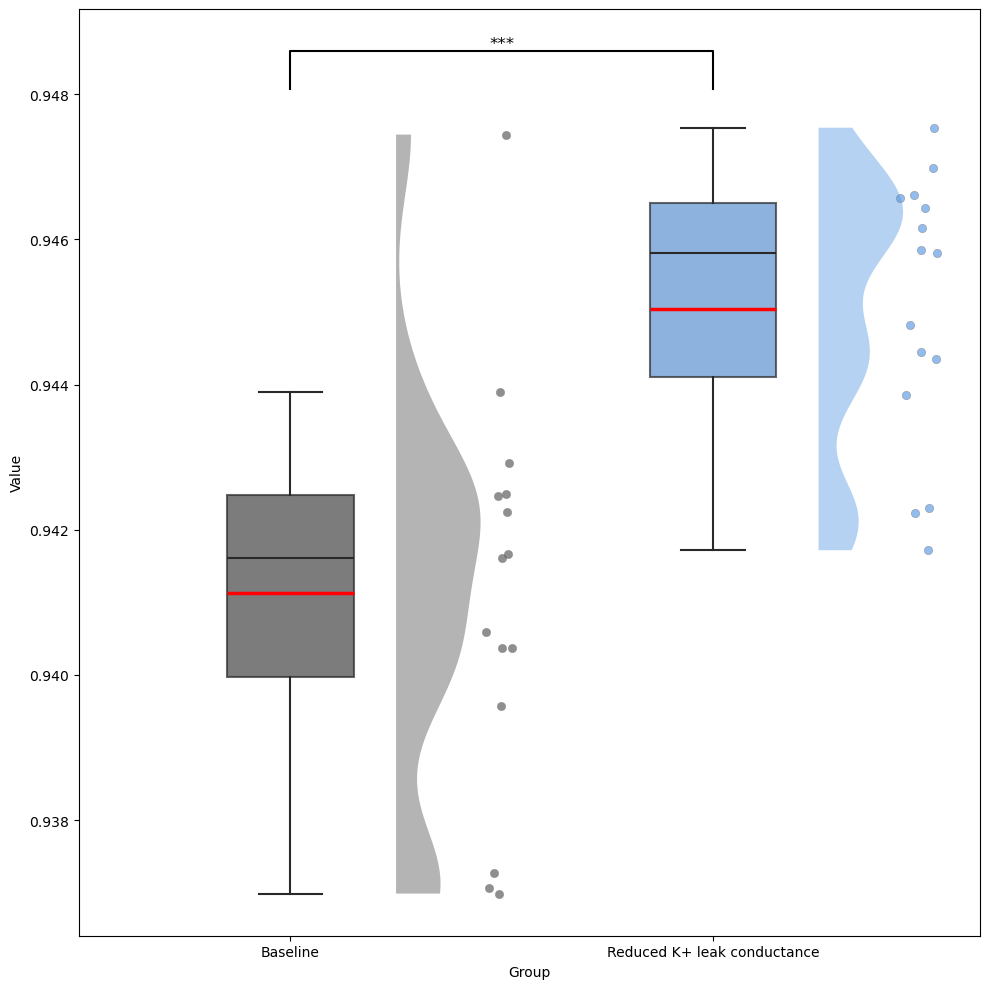

In [71]:
# Compute & plot LZc, LZc_single
entropies_names = ['LZc_single','LZc']
figsize = (10,10)
entropies = np.zeros((len(entropies_names),len(simconfigs),n_minimal_seeds))
for i,entropy_name in enumerate(entropies_names):
    for j,simconfig in enumerate(simconfigs):
            entropies[i,j] = parallelized_entropy(
                simconfig, seeds=noexp_ai_seeds[j], entropy_name=entropy_name, n_tasks_concurrent=n_tasks_concurrent, 
                save_path=simu_path, simu_path=simu_path, data=data[j])
    plot_box_points_violin(
        simconfigs=simconfigs,
        file_prefix=entropy_name,
        n_seeds=n_minimal_seeds,
        figsize=figsize,
        save=1,
        path=simu_path,
        x=x,
        save_path=img_save_path,
        file_name=f'{entropy_name}.png',
        box_colors=colors
    )